<a href="https://colab.research.google.com/github/Kibika/causal_inference/blob/master/notebooks/causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAUSAL INFERENCE
This analysis will use the Wisconsin cancer dataset to perform causal inference. We will be plotting causal graphs to determine the relationships between variables, both independent and dependent. The causal graph should give an idea of which independent variables directly affect the dependent variable. We will compare a model trained on all the variables and a model trained based on the variables chosen from the causal graph using evaluation metrics from the confusion matrix.

First, we will perform data exploration and any necessary cleaning. The data exploration will give an initial idea about how the variables relate to each other from the observed data.

In [ ]:
! pip install causalgraphicalmodels

In [ ]:
! apt install libgraphviz-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
! pip install pygraphviz

In [ ]:
! pip install wrapt --upgrade

  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=c3f4a91774ccf45ff14222fba8a5d8414fcc63597bba6c3c0d1e7ce247f8db05
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
causalnex 0.10.0 requires wrapt<1.12,>=1.11.0, but you have wrapt 1.12.1 which is incompatible.


In [ ]:
! pip install causalnex


  Using cached wrapt-1.11.2-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.12.1
    Uninstalling wrapt-1.12.1:
      Successfully uninstalled wrapt-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires wrapt~=1.12.1, but you have wrapt 1.11.2 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas, from_pandas_lasso
import pygraphviz
from causalnex.inference import InferenceEngine
from causalnex.evaluation import roc_auc
from causalnex.evaluation import classification_report
from causalnex.network import BayesianNetwork

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPROCESSING AND EXPLORATION
The goal of this is to understand the data and any tasks that need to be done to prepare it for training using a machine learning model. We should also get an understanding of the distributions of the variables and how they correlate to one another.

In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/speech/data/result_dataframe.csv")

In [ ]:
# dataset = pd.read_csv("/content/drive/My Drive/speech/data/data.csv")

In [ ]:
dataset.head()

,Unnamed: 0,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0,8670,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,1,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,2,8915,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,3,9047,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,4,85715,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [ ]:
dataset=dataset.drop(['Unnamed: 0'],axis=1)

In [ ]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,8670,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,8915,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,9047,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,85715,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [ ]:
#checking data types and missing values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
# summary measures
dataset.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


UNIVARIATE PLOTS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Frequency of Diagnosis')

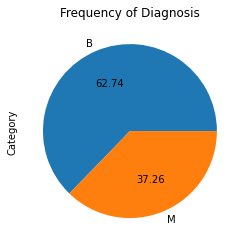

In [ ]:
#pie chart showing the proportion of M = Malignant(presence of cancer cells) compared to B = Benign(absence of cancer cells)
dataset.groupby('diagnosis').size().plot(kind='pie', autopct='%.2f')
plt.axes().set_ylabel('Category')
plt.title('Frequency of Diagnosis')


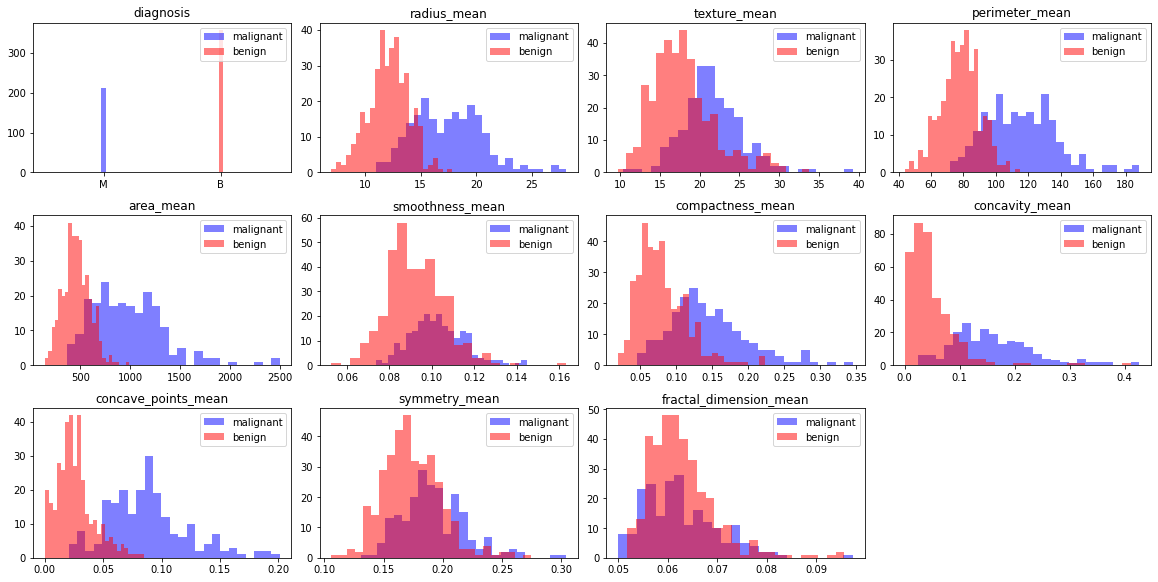

In [ ]:
#Plot histograms of "_mean" variables group by diagnosis
df = dataset[['diagnosis', "radius_mean", "texture_mean","perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean"]].copy()
# df.plot.hist(subplots = True,  layout = (3,4), figsize = (8,6))
# df.pivot(columns='diagnosis').radius_mean.plot.hist()
def diag(col):
    M = df[df['diagnosis'] == 'M'][col]
    B = df[df['diagnosis'] == 'B'][col]
    return M, B

plt.figure(figsize=(16, 8))
for num, alpha in enumerate(df.columns):
    plt.subplot(3, 4, num+1)
    plt.hist(diag(alpha)[0], bins=25, alpha=0.5, label='malignant', color='b')
    plt.hist(diag(alpha)[1], bins=25, alpha=0.5, label='benign', color='r')
    plt.legend(loc='upper right')
    plt.title(alpha)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


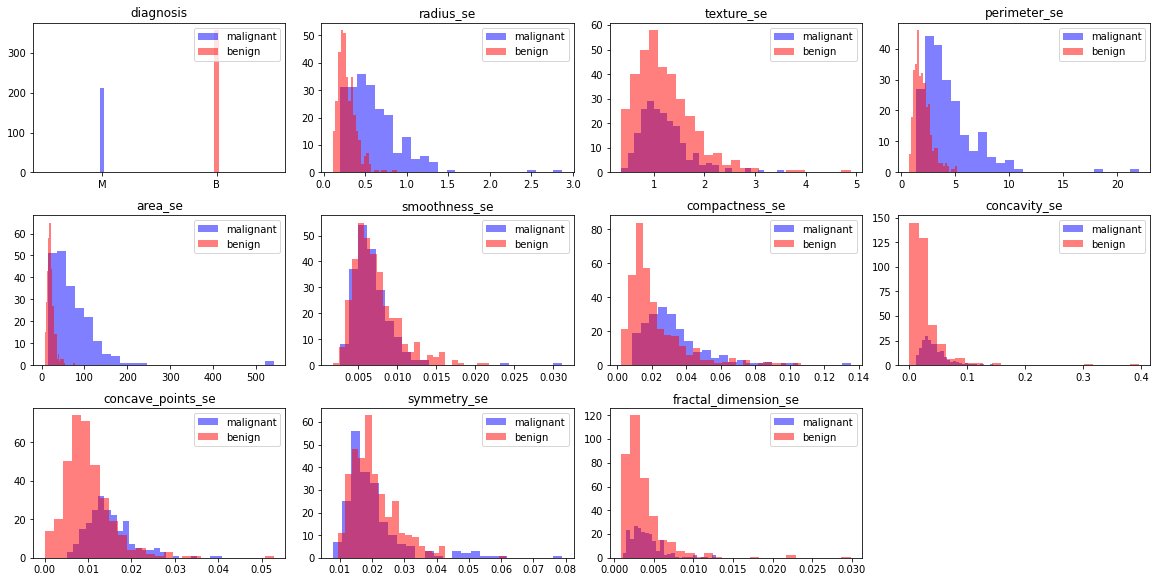

In [ ]:
#Plot histograms of "_se" variables group by diagnosis
df = dataset[['diagnosis', "radius_se", "texture_se","perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se"]].copy()
# df.plot.hist(subplots = True,  layout = (3,4), figsize = (8,6))
# df.pivot(columns='diagnosis').radius_mean.plot.hist()
def diag(col):
    M = df[df['diagnosis'] == 'M'][col]
    B = df[df['diagnosis'] == 'B'][col]
    return M, B
    
plt.figure(figsize=(16, 8))
for num, alpha in enumerate(df.columns):
    plt.subplot(3, 4, num+1)
    plt.hist(diag(alpha)[0], bins=25, alpha=0.5, label='malignant', color='b')
    plt.hist(diag(alpha)[1], bins=25, alpha=0.5, label='benign', color='r')
    plt.legend(loc='upper right')
    plt.title(alpha)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

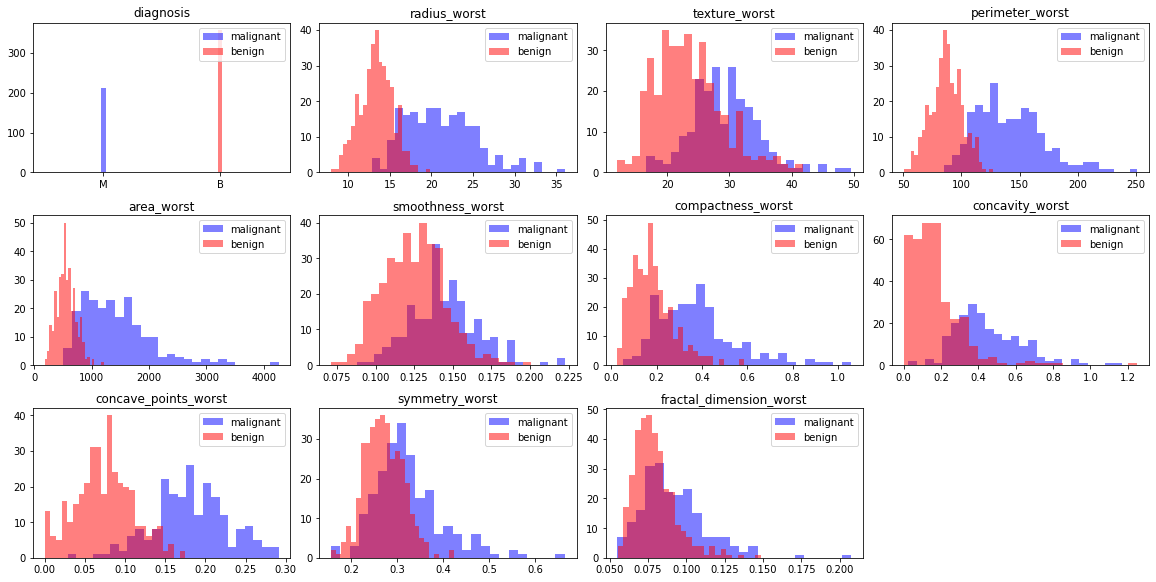

In [ ]:
#Plot histograms of "_worst" variables group by diagnosis
df = dataset[['diagnosis', "radius_worst", "texture_worst","perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"]].copy()
# df.plot.hist(subplots = True,  layout = (3,4), figsize = (8,6))
# df.pivot(columns='diagnosis').radius_mean.plot.hist()
def diag(col):
    M = df[df['diagnosis'] == 'M'][col]
    B = df[df['diagnosis'] == 'B'][col]
    return M, B
    
plt.figure(figsize=(16, 8))
for num, alpha in enumerate(df.columns):
    plt.subplot(3, 4, num+1)
    plt.hist(diag(alpha)[0], bins=25, alpha=0.5, label='malignant', color='b')
    plt.hist(diag(alpha)[1], bins=25, alpha=0.5, label='benign', color='r')
    plt.legend(loc='upper right')
    plt.title(alpha)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

The plots of distribution comparing distribution of M and B in the different variables show an overlap in the distributions, the features are not distinctly separated.

BIVARIATE PLOTS

In [ ]:
corr=dataset.iloc[:,2:32].corr()
corr

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


Text(0.5, 1.0, 'Correlation Heatmap')

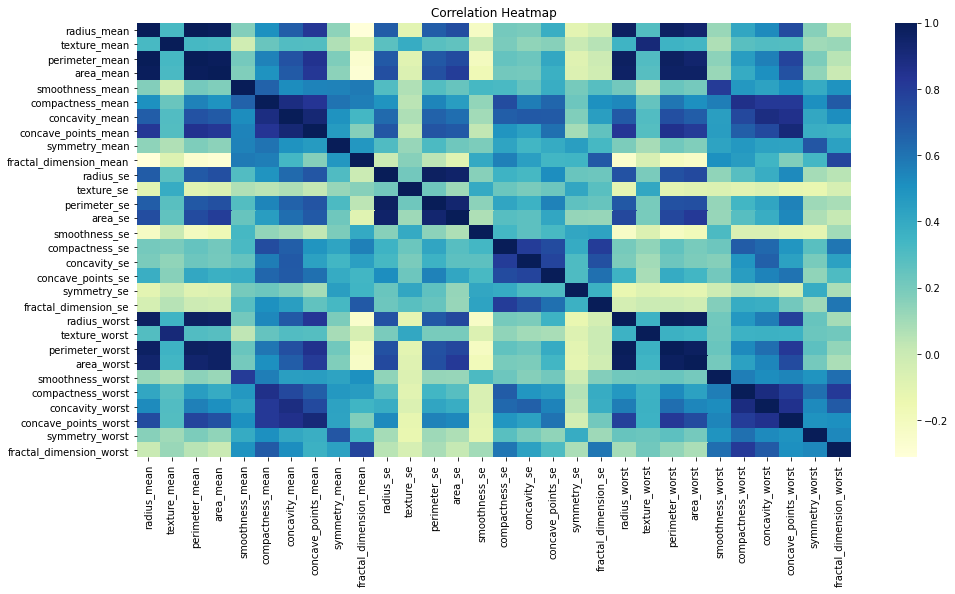

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(corr,cmap="YlGnBu")
plt.title("Correlation Heatmap")

OUTLIERS

In [ ]:
# plt.figure(figsize=(20, 20))
# df.plot(kind='box')

In [ ]:
# sns.boxplot(dataset['symmetry_se'],data=dataset)


In [ ]:
# #outlier detection and replacement by median
# def outlier(df):
#   column_name=list(df.columns[2:])
#   for i in column_name:
#     upper_quartile=df[i].quantile(0.75)
#     lower_quartile=df[i].quantile(0.25)
#     df[i]=np.where(df[i]>upper_quartile,df[i].mean(),np.where(df[i]<lower_quartile,df[i].median(),df[i]))
#   return df

In [ ]:
# plt.figure(figsize=(20, 20))
# outlier(dataset).plot(kind='box')

In [ ]:
# sns.boxplot(dataset['symmetry_se'],data=outlier(dataset))


In [ ]:
# import plotly.express as px
# for x in ['radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
# 'concave_points_worst','symmetry_worst']:
#   fig = px.histogram(df, x=x, marginal="box",
#   hover_data=df.columns)
#   fig.show()

In [ ]:
# import plotly.express as px
# for x in ['radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
# 'concave_points_worst','symmetry_worst']:
#   fig = px.histogram(outlier(df), x=x, marginal="box",
#   hover_data=outlier(df).columns)
#   fig.show()

FEATURE EXTRACTION AND SCALING.

The code used in this section is adapted from https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb

In [ ]:
#pca
#scaling the variables
features = list(dataset.columns[2:])
# Separating out the features
x = dataset.loc[:, features].values
# Separating out the target
y = dataset.loc[:,['diagnosis']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, dataset[['diagnosis']]], axis = 1)

In [ ]:
finalDf.head()

,principal component 1,principal component 2,diagnosis
0,1.432069,-1.049604,M
1,-4.312130,-1.978486,B
2,-0.417837,-0.808577,B
3,-2.473293,-0.335047,B
4,1.700007,2.352272,M


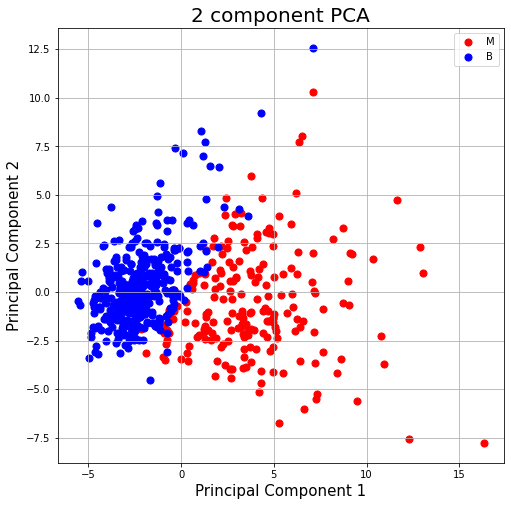

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['M', 'B']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The components distinguish between the classes quite well with a little overlap

In [ ]:
pca.explained_variance_ratio_


array([0.44272026, 0.18971182])

The first component explains 44% of the variation, while the second component explains 19% of the variation. The two components used together will explain 63% of the variation. Adding a third component may improve the variation explained by the components.

In [ ]:
# biplot


Using PCA for feature selection would allow us to observe the number of components but it would be difficult to explain the features influencing the outcome when plotting causal graphs and inputting the components chosen into an algorithm for training. In the next section we explore methods that we can use for feature selection while preserving the variables as they are.

# FEATURE SELECTION
Several methods can be applied to do feature selection. Some are listed below:
*   Using correlation - use the correlation matrix to check which variable are highly correlated and retain only one of the correlated variables.
*   Univariate feature selection
*   Recursive feature elimination (forward or backward elimination can be applied)
*   Recursive feature elimination with cross validation
*   Tree based feature selection

The first four models can be tested by training a classification algorithm and checking the evaluation metrics.

Here we will use tree based feature selection to extract feature importance and determine the number of features to use.







In [ ]:
#drop id column
diagnosis_data = dataset.copy()
diagnosis_data = diagnosis_data.drop(['id'],axis=1)
diagnosis_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [ ]:
#encode diagnosis column (any non-numeric columns in the dataset)
# Malignant = 1
# Benign = 0
le = LabelEncoder()
diagnosis_data['diagnosis'] = le.fit_transform(diagnosis_data['diagnosis'])
diagnosis_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,0,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,0,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,0,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


# Split the dataset into train, validation and test sets

In [ ]:
X = diagnosis_data.drop(["diagnosis"], axis=1)
y = diagnosis_data["diagnosis"]

In [ ]:
# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

# Train and predict using random forest classifier

In [ ]:
# create the classifier
classifier = RandomForestClassifier(n_estimators=100)

In [ ]:
# Train the model using the training sets
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# predictin on the test set
y_pred = classifier.predict(X_test)

In [ ]:
rf_cnm=confusion_matrix(y_test, y_pred)
print('log_results') 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

log_results
Accuracy Score : 0.9649122807017544
Precision: 0.9130434782608695
Recall: 1.0


Text(0.5, 15.0, 'Predicted label')

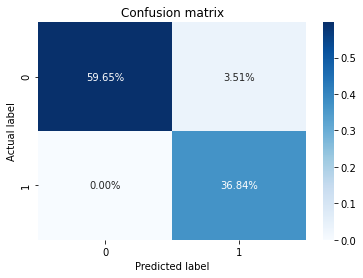

In [ ]:
# create heatmap
sns.heatmap(rf_cnm/np.sum(rf_cnm), annot=True ,fmt='.2%', cmap='Blues')
ax.xaxis.set_label_position("top")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The evaluation metrics show that the model is performing quite well. 3.51% of the values that are benign are being predicted as malignant. All malignant cells are predicted correctly.


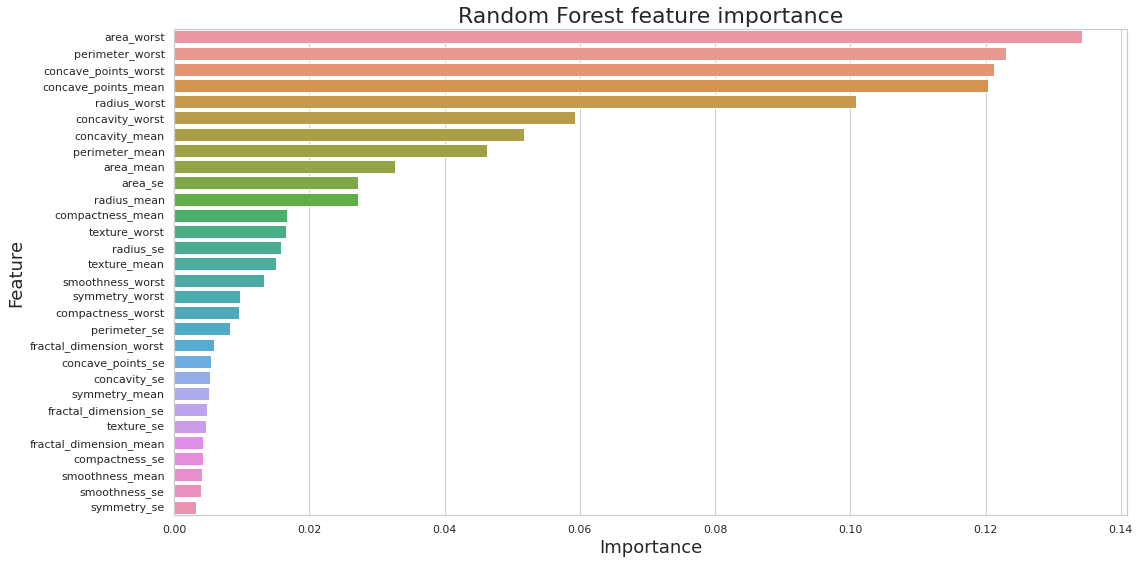

In [ ]:
# get importance
importances = classifier.feature_importances_
labels = X.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns=["feature", "importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False, )

# image formatting
axis_fs = 18  # fontsize
title_fs = 22  # fontsize
sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance', fontsize=axis_fs)
ax.set_ylabel('Feature', fontsize=axis_fs)  # ylabel
ax.set_title('Random Forest feature importance', fontsize=title_fs)


plt.tight_layout()
# plt.savefig("feature_importance.png", dpi=120)
plt.show()

Since the model has a good performance we can use it to choose the values that are important. The plot above ranks the features based on their importance. A scree plot can be used to determine the number of features to retain in PCA, with a random forest we can 'get_support' from the tained model.

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X.columns[(sel.get_support())]
selected_feat

Index(['perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean',
       'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst',
       'concave_points_worst'],
      dtype='object')

We have 8 features that have been chosen as important, and the features also have a high importance from the graph of important features. The dataset input into the causalnex package will contain these 8 features

In [ ]:
diagnosis_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.0940,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,0,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.01345,0.01652,0.005905,0.01619,0.002081,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,0,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.1710,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,0,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,1,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,0.2871,0.8937,1.8970,24.25,0.006532,0.02336,0.02905,0.012150,0.01743,0.003643,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


CAUSAL GRAPH

In [ ]:
#filter original dataset to retain the important variables
#the dimension of the dataset has reduced from 569,32 to 569,9
causal_data = diagnosis_data[['diagnosis','area_mean', 'concavity_mean', 'concave_points_mean', 'radius_worst',
       'perimeter_worst', 'area_worst', 'concavity_worst',
       'concave_points_worst']].copy()
causal_data.head()

,diagnosis,area_mean,concavity_mean,concave_points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave_points_worst
0,1,748.9,0.14660,0.08087,19.26,124.90,1156.0,0.3791,0.15140
1,0,515.9,0.02260,0.01171,13.62,87.40,577.0,0.1186,0.05366
2,0,687.3,0.05940,0.04819,16.25,109.10,809.8,0.1804,0.14890
3,0,507.6,0.03296,0.02390,13.86,89.69,580.9,0.1810,0.08388
4,1,534.6,0.12260,0.07340,15.67,102.80,759.4,0.5006,0.20880


In [ ]:
causal_data.shape

(569, 9)

# CAUSAL GRAPH

Structure Learning

The graph generated will enable us establish the relationship between the variables. The graph can be plotted with or without lasso regularization.

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


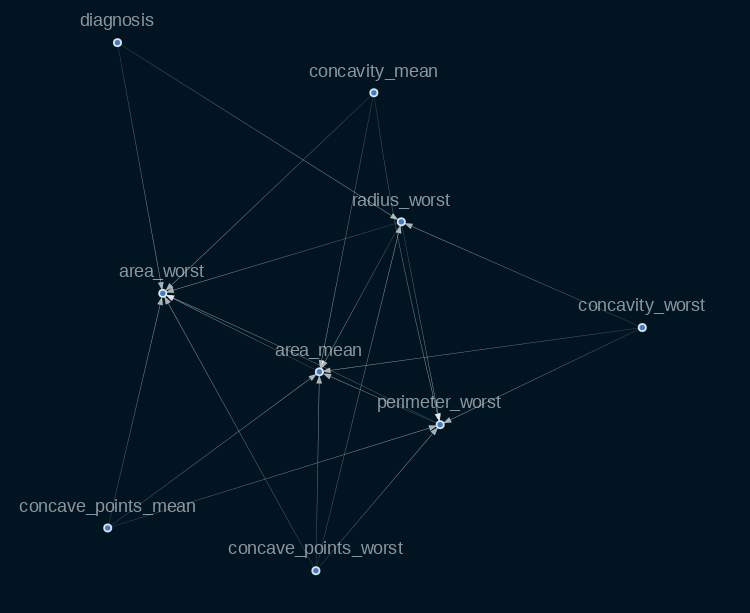

In [ ]:
sm = from_pandas(causal_data, w_threshold=0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


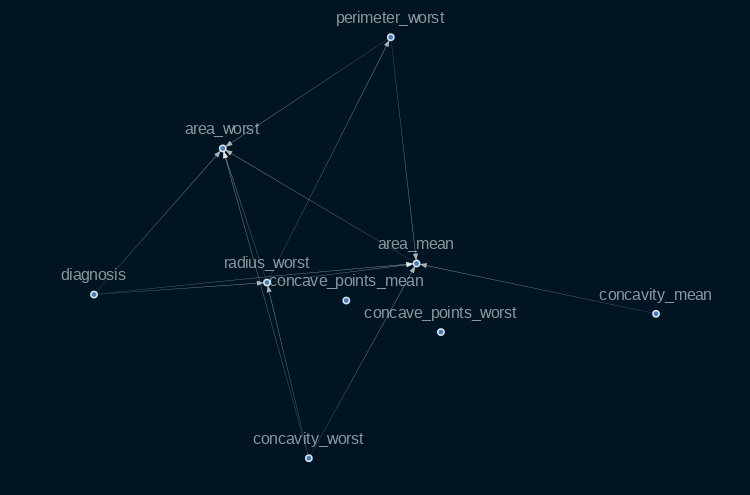

In [ ]:
sm = from_pandas_lasso(causal_data, w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In this graph the outcome variable(diagnosis) is the one influencing the other variables, to avoid this we will add a constraint that prevents it from being a parent to any of the nodes. We will first add the constraint without lasso constraint and because of the small amount of data we will also draw the graph with lasso regularization.

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


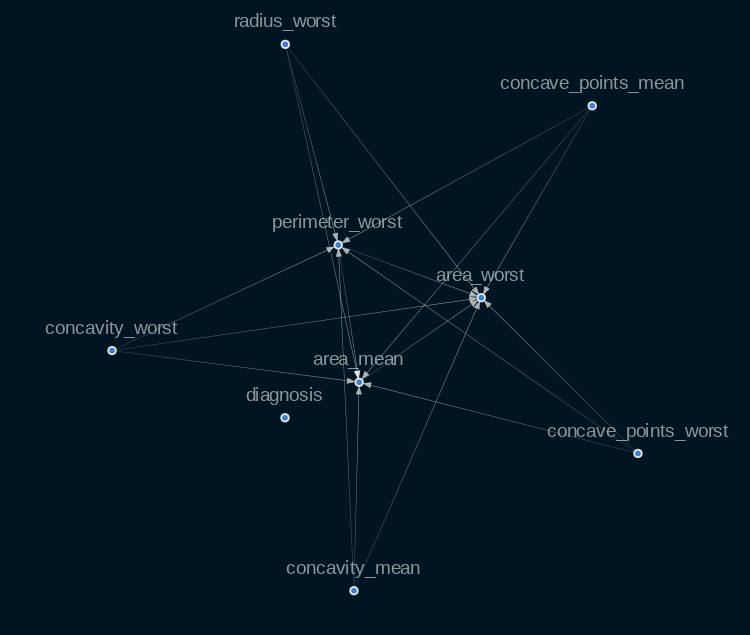

In [ ]:
#add constraint to diagnosis without lasso regularization
sm_constrained = from_pandas(causal_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8)
viz = plot_structure(
    sm_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


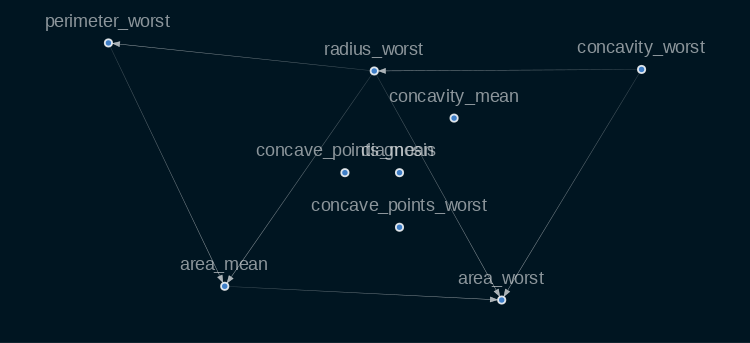

In [ ]:
#put constraint on diagnosis column with lasso regularization
sm_lasso_constrained = from_pandas_lasso(causal_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_lasso_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

Structure Review

Radius affects perimeter and area, 

concavity affects radius and eventually perimeter and area,

the graph captures these relationships.

# Jaccard's similarity index
Using intersection

In [ ]:
#similarity between a graph plotted without lasso regularization and one plotted with lasso regularization
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

jaccard_similarity(sm_constrained.edges(), sm_lasso_constrained.edges())

0.316

Using Union and intersection

In [ ]:
def Jaccar_score(g, h):    
    i = set(g).intersection(set(h))
    u = set(g).union(set(h))
    return len(i) / float(len(u))

Split the data rowwise and test the model as we increase the data

In [ ]:
df_1 = causal_data.iloc[:100,:]
df_2 = causal_data.iloc[:300,:]
df_3 = causal_data.iloc[:,:] 

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


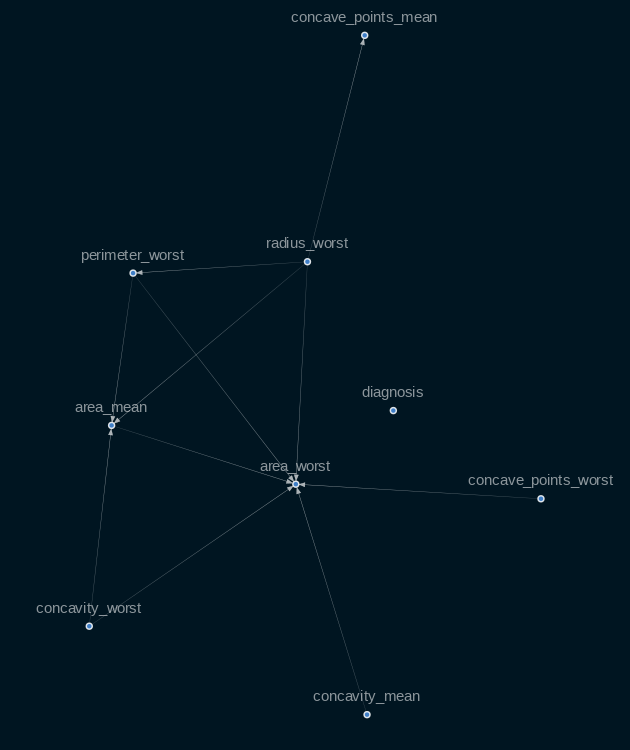

In [ ]:
sm_df1 = from_pandas_lasso(df_1, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df1,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


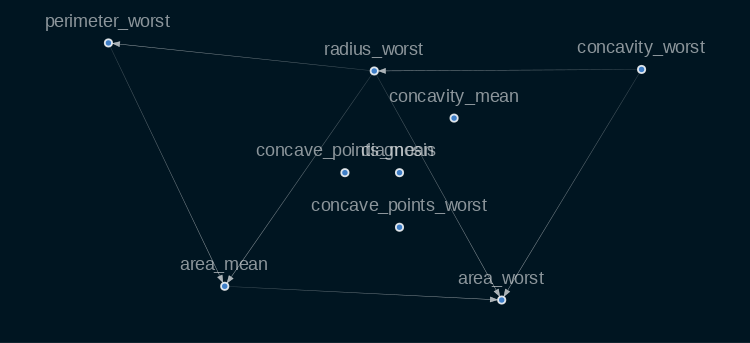

In [ ]:
sm_df2 = from_pandas_lasso(df_2, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df2,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [ ]:
# similarity between df_1 and df_2
jaccard_similarity(sm_df1.edges(), sm_df2.edges())

0.5

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


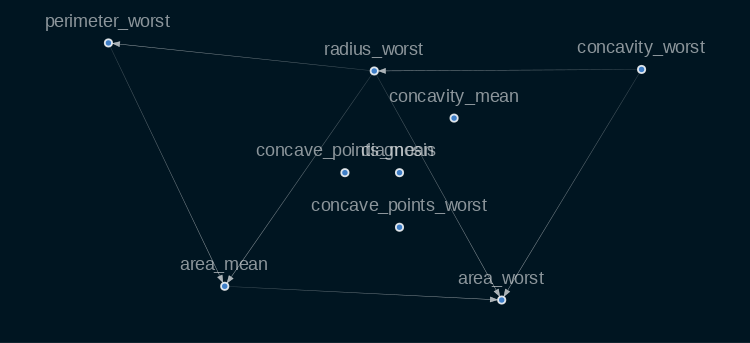

In [ ]:
sm_df3 = from_pandas_lasso(df_3, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = plot_structure(
    sm_df3,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [ ]:
# similarity between df_2 and df_3
jaccard_similarity(sm_df2.edges(), sm_df3.edges())

1.0

In [ ]:
#similarity using union and intersection
Jaccar_score(sm_df2.edges(), sm_df3.edges())

1.0

The graph has similarity of 1 between the second and third dataframe, the second dataframe had 300 observations while the third dataframe had all the 569 observations. 

The relationship between the independent variables remains stable and will be used to generate the final graph.

FINAL GRAPH

If radius and concavity affects, area and perimeter, we will add the relationships, below, radius and concavity will not directly affect the outcome but area, perimeter and concave_points will affect the outcome

In [ ]:
sm_lasso_constrained.add_edge("concave_points_mean", "diagnosis")
sm_lasso_constrained.add_edge("concave_points_worst", "diagnosis")
sm_lasso_constrained.add_edge("area_worst", "diagnosis")
sm_lasso_constrained.add_edge("area_mean", "diagnosis")
sm_lasso_constrained.add_edge("perimeter_worst", "diagnosis")
sm_lasso_constrained.add_edge("concavity_mean", "area_mean")

/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


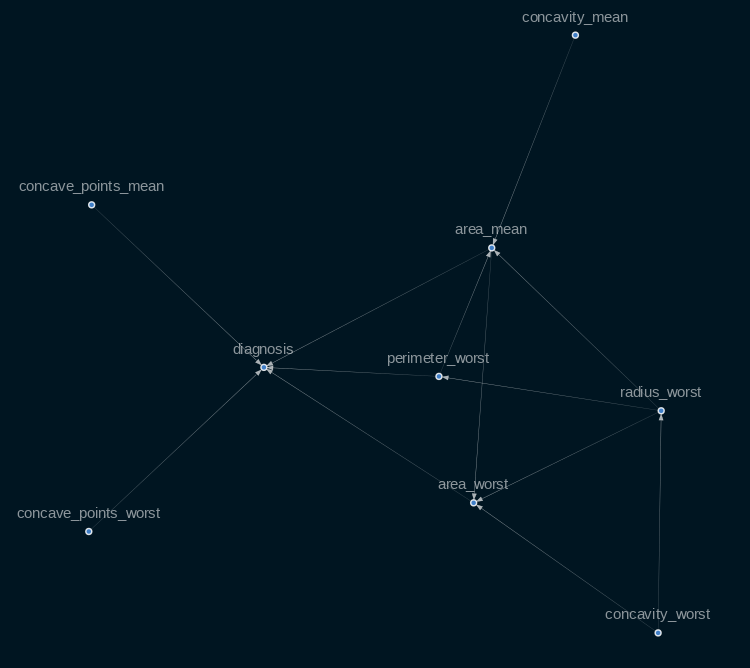

In [ ]:
viz = plot_structure(
    sm_lasso_constrained,
    graph_attributes={"scale": "2.0", 'size':2.5},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

# Bayesian Network
The Bayesian network is used to fit the data. Bayesian approaches are based on conditional probabilities or information that is known prior. The Bayesian network here learns the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit, https://causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html.

The fitted, conditional probabilities/ bayesian network are used to predict and evaluation metrics for classification models such as precision and recall are used to evaluate the model.

In [ ]:
discretised_data = causal_data.copy()

data_vals = {col: causal_data[col].unique() for col in causal_data.columns}

diagnosis_map = {v: 'benign' if v == [0]
            else 'malignant' for v in data_vals['diagnosis']}

In [ ]:
discretised_data["diagnosis"] = discretised_data["diagnosis"].map(diagnosis_map)


In [ ]:
# data_vals = {col: causal_data[col].unique() for col in causal_data.columns}

# for i in list(discretised_data.columns):
#   if i==str(diagnosis):
#     map = {v: 'benign' if v == [0]
#             else 'malignant' for v in data_vals['diagnosis']}
#     discretised_data["diagnosis"] = discretised_data["diagnosis"].map(map)
#   else:
#     map  = {v: 'small' if v <= (discretised_data[str(i)].max()-discretised_data[str(i)].min())/2
#             else 'large' for v in data_vals[str(i)]}
#     discretised_data[str(i)] = discretised_data[str(i)].map(map)

# print(discretised_data)



In [ ]:
for i in list(discretised_data.columns[1:]):
  map  = {v: 'small' if v <= (discretised_data[str(i)].max()-discretised_data[str(i)].min())/2
            else 'large' for v in data_vals[str(i)]}
  discretised_data[str(i)] = discretised_data[str(i)].map(map)



In [ ]:
discretised_data.head()

,diagnosis,area_mean,concavity_mean,concave_points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave_points_worst
0,malignant,small,small,small,large,large,small,small,large
1,benign,small,small,small,small,small,small,small,small
2,benign,small,small,small,large,large,small,small,large
3,benign,small,small,small,small,small,small,small,small
4,malignant,small,small,small,large,large,small,small,large


In [ ]:
# Split 80% train and 20% test
train, test = train_test_split(discretised_data, train_size=0.8, test_size=0.2, random_state=7)

In [ ]:
bn = BayesianNetwork(sm_lasso_constrained)

In [ ]:
bn = bn.fit_node_states(discretised_data)

In [ ]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [ ]:
pred = bn.predict(test, 'diagnosis')

In [ ]:
true = np.where(test['diagnosis'] == 'malignant', 1, 0)
pred = np.where(pred == 'malignant', 1, 0)

In [ ]:
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.87
Accuracy: 0.95 
Precision: 0.97 


The metrics are almost similar to the metrics derived from training a random forest with all the variables.

In [ ]:
classification_report(bn, test, "diagnosis")

{'accuracy': 0.9473684210526315,
 'diagnosis_benign': {'f1-score': 0.9615384615384615,
  'precision': 0.9375,
  'recall': 0.9868421052631579,
  'support': 76},
 'diagnosis_malignant': {'f1-score': 0.9166666666666667,
  'precision': 0.9705882352941176,
  'recall': 0.868421052631579,
  'support': 38},
 'macro avg': {'f1-score': 0.9391025641025641,
  'precision': 0.9540441176470589,
  'recall': 0.9276315789473684,
  'support': 114},
 'weighted avg': {'f1-score': 0.9465811965811965,
  'precision': 0.9485294117647058,
  'recall': 0.9473684210526315,
  'support': 114}}

Both classes have high recall and precision values, that means they are being predicted well with a few misclassifications

In [ ]:
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

0.9755309325946444


ROC is a probability curve and AUC represents the degree or measure of separability.It tells how much the model is capable of distinguishing between classes, https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5.

The area under the curve(AUC) is high indicating good performance 
of the model.


In [ ]:
#conditional probalities
bn.cpds["diagnosis"]

area_mean                large              ... small                    
area_worst               large              ... small                    
concave_points_mean      large              ... small                    
concave_points_worst     large       small  ... large     small          
perimeter_worst          large small large  ... small     large     small
diagnosis                                   ...                          
benign                0.066667   0.5   0.5  ...  0.75  0.594595  0.982979
malignant             0.933333   0.5   0.5  ...  0.25  0.405405  0.017021

[2 rows x 32 columns]

The probability of having malignant cells when the independent variables are all large is 93%

# Querying

In [ ]:
#fit the data on the entire dataset
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")


In [ ]:
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["diagnosis"]

{'benign': 0.6176684109464512, 'malignant': 0.3823315890535487}

In [ ]:
marginals_small = ie.query({"area_mean": "small"})
marginals_large = ie.query({"area_mean": "large"})
print("Marginal diagnosis | Small area mean", marginals_small["diagnosis"])
print("Marginal diagnosis | Large area mean", marginals_large["diagnosis"])

Marginal diagnosis | Small area mean {'benign': 0.6518797377141716, 'malignant': 0.3481202622858284}
Marginal diagnosis | Large area mean {'benign': 0.30262765584276924, 'malignant': 0.6973723441572307}


A smaller area mean of cells makes it more likely to be benign while a larger area mean of cells makes it more likely to be malignant.